In [1]:
# 必要なパッケージをインポート
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from statsmodels.graphics.tsaplots import plot_acf


In [2]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt

In [3]:
print(np.__version__)
print(pm.__version__)
print(az.__version__)

1.23.5
5.7.2
0.15.1


## データの準備など

In [4]:
# データ用意
parray1 = pd.read_csv(f"../data/4-2-1-fish-num-3.csv")
df1 = pd.DataFrame(parray1)
print(df1.shape)
display(df1.head())

parray2 = pd.read_csv(f"../data/4-3-1-fish-num-4.csv")
df2 = pd.DataFrame(parray2)
print(df2.shape)
display(df2.head())

(100, 4)


,fish_num,weather,temperature,human
0,1,cloudy,6.0,A
1,7,cloudy,20.6,B
2,12,cloudy,27.5,C
3,0,cloudy,8.5,D
4,0,cloudy,3.1,E


(94, 3)


,fish_num,temperature,human
0,2,12.7,A
1,6,13.7,B
2,9,15.7,C
3,5,19.1,D
4,11,12.0,E


## ランダム切片モデル

### 可視化

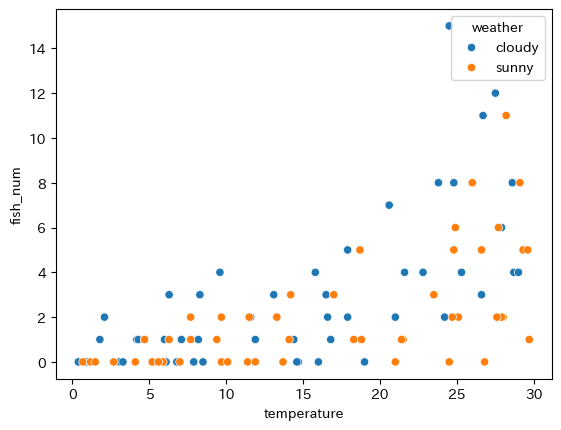

In [5]:
# データの可視化(天気ごと)
fig, ax = plt.subplots()
ax = sns.scatterplot(x = parray1["temperature"], y = parray1["fish_num"],
                     hue = parray1["weather"])

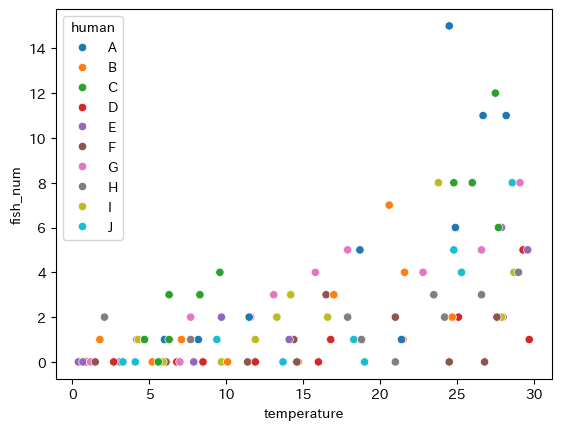

In [6]:
# データの可視化(humanごと)
fig, ax = plt.subplots()
ax = sns.scatterplot(x = parray1["temperature"], y = parray1["fish_num"],
                     hue = parray1["human"])

### ベイズ推論

In [7]:
# データの準備
y = parray1["fish_num"].values
weather = pd.get_dummies(df1["weather"], dtype=int, drop_first=True).values.reshape(-1)
temperature = df1["temperature"].values
cl = pd.Categorical(df1["human"]).codes

print(y[:5])
print(weather[:5])
print(temperature[:5])
print(df1["human"][:5])
print(cl[:5])


[ 1  7 12  0  0]
[0 0 0 0 0]
[ 6.  20.6 27.5  8.5  3.1]
0    A
1    B
2    C
3    D
4    E
Name: human, dtype: object
[0 1 2 3 4]


In [8]:
# # 確率モデルの定義
# model = pm.Model()

# with model:
#     # 観測値をConstantDataとして定義
#     y_data = pm.Data("y_data", y, mutable=True)
#     weather_data = pm.Data("weather_data", weather, mutable=True)
#     temperature_data = pm.Data("temperature_data", temperature, mutable=True)

#     # パラメータを確率変数として定義
#     b0 = pm.Normal("b0", mu=0, sigma=10000)
#     b_w = pm.Normal("b_w", mu=0, sigma=10000)
#     b_t = pm.Normal("b_t", mu=0, sigma=10000)

#     # 目的変数の期待値を確率変数として定義
#     exp_lambda_ = pm.Deterministic("exp_lambda_", 
#                                    pt.exp(b_w * weather_data + b_t * temperature_data + b0))

#     # 観測値を持つ確率変数として定義
#     y_obs = pm.Poisson("y_obs", mu=exp_lambda_, observed=y_data)

# g = pm.model_to_graphviz(model)
# display(g)

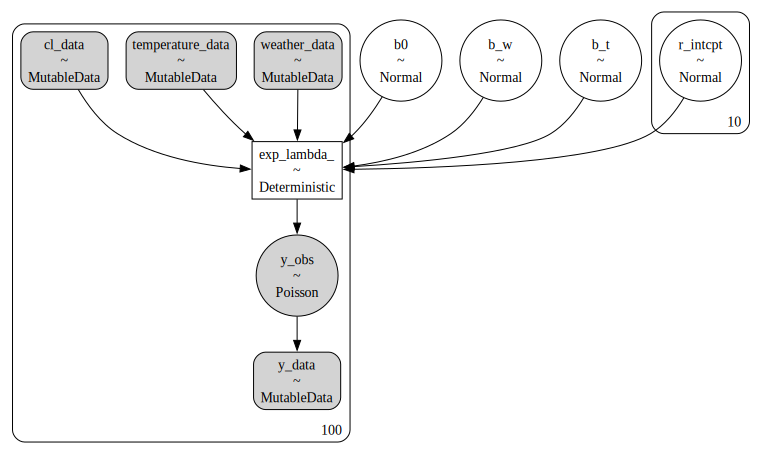

In [17]:
# 確率モデルの定義
model = pm.Model()

with model:
    # 観測値をConstantDataとして定義
    y_data = pm.Data("y_data", y, mutable=True)
    weather_data = pm.Data("weather_data", weather, mutable=True)
    temperature_data = pm.Data("temperature_data", temperature, mutable=True)

    # クラス変数を定義
    cl_data = pm.Data("cl_data", cl, mutable=True)

    # パラメータを確率変数として定義
    b0 = pm.Normal("b0", mu=0, sigma=100)
    b_w = pm.Normal("b_w", mu=0, sigma=100)
    b_t = pm.Normal("b_t", mu=0, sigma=100)

    # ランダム切片効果を定義
    r_intcpt = pm.Normal("r_intcpt", mu=0, sigma=100, shape=(10, ))

    # 目的変数の期待値を確率変数として定義
    exp_lambda_ = pm.Deterministic("exp_lambda_", 
                                   pt.exp(b_w * weather_data + b_t * temperature_data + b0 + r_intcpt[cl_data]))

    # 観測値を持つ確率変数として定義
    y_obs = pm.Poisson("y_obs", mu=exp_lambda_, observed=y_data)

g = pm.model_to_graphviz(model)
display(g)

In [18]:
# パラメータのMCMCサンプリング
with model:
    idata1 = pm.sample(
        chains = 2,
        tune = 8000,
        draws = 2000,
        random_seed = 42,
        target_accept = 0.99
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b0, b_w, b_t, r_intcpt]


Sampling 2 chains for 8_000 tune and 2_000 draw iterations (16_000 + 4_000 draws total) took 1262 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


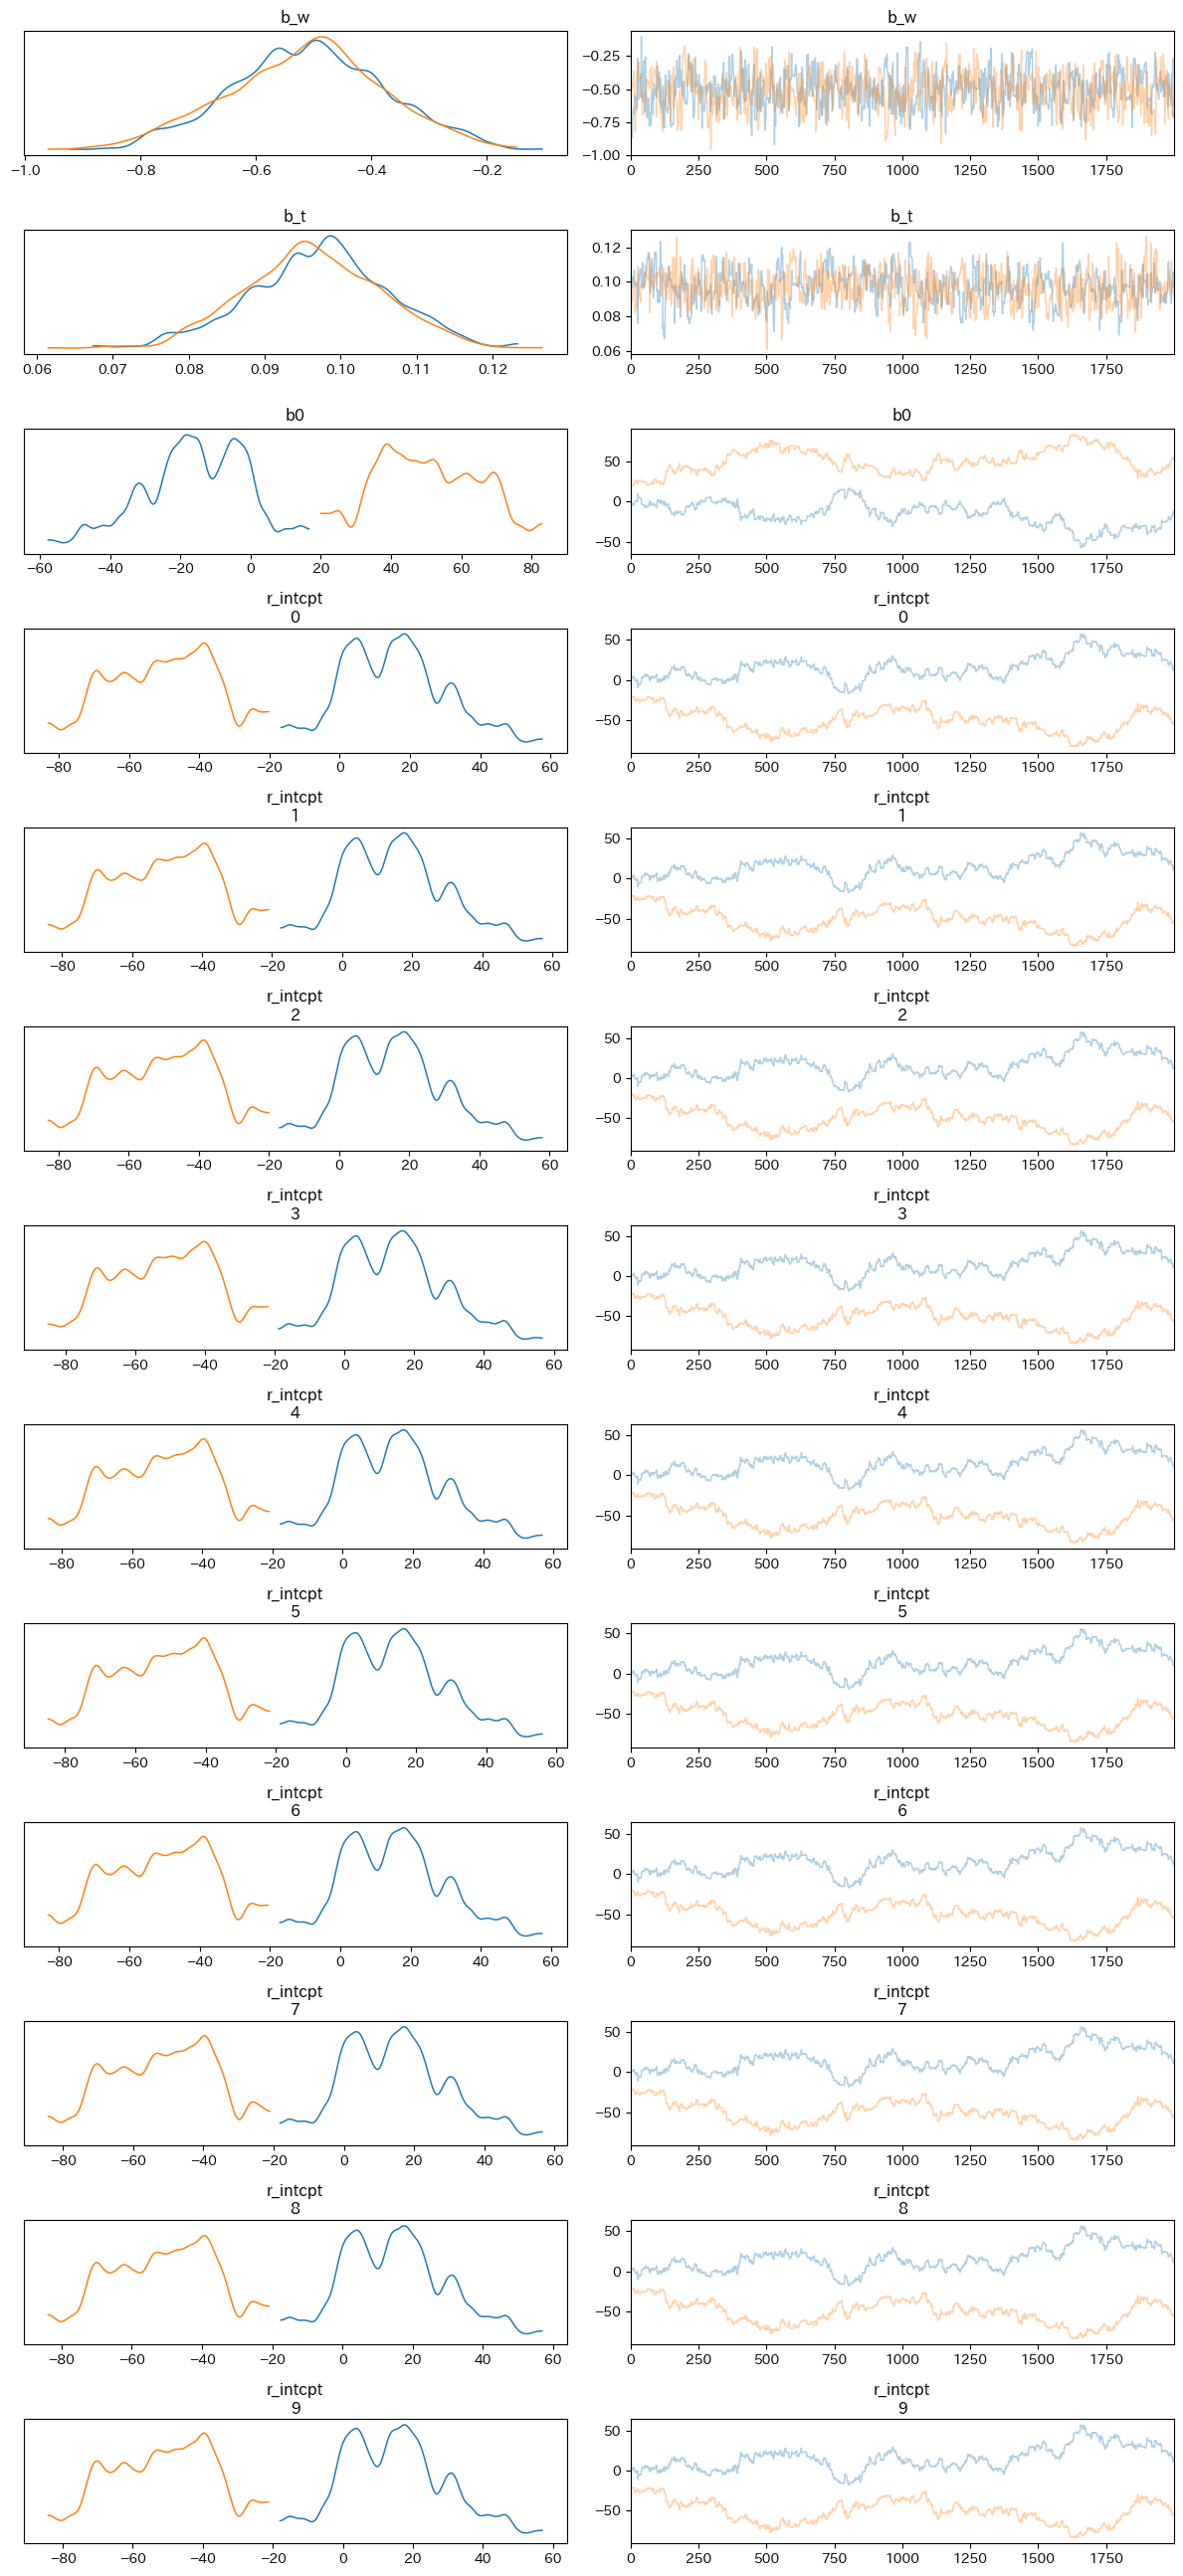

In [19]:
# 事後分布の可視化
az.plot_trace(idata1, compact=False, var_names=["b_w", "b_t", "b0", "r_intcpt"])
# az.plot_trace(idata1, compact=False, var_names=["b_w", "b_t", "b0"])
plt.tight_layout();

In [20]:
# MCMCサンプルの統計量
az.summary(idata1, var_names=["b_w", "b_t", "b0", "r_intcpt"])
# az.summary(idata1, var_names=["b_w", "b_t", "b0"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_w,-0.511,0.133,-0.782,-0.275,0.006,0.004,546.0,851.0,1.00
b_t,0.097,0.009,0.080,0.114,0.000,0.000,428.0,531.0,1.02
b0,17.162,36.258,-38.156,73.738,23.972,19.756,3.0,14.0,1.97
r_intcpt[0],-17.223,36.246,-73.731,38.165,23.966,19.752,3.0,14.0,1.97
r_intcpt[1],-17.925,36.252,-74.495,37.486,23.971,19.756,3.0,14.0,1.97
r_intcpt[2],-17.281,36.243,-73.612,38.240,23.963,19.749,3.0,14.0,1.97
r_intcpt[3],-18.838,36.239,-75.459,36.599,23.956,19.742,3.0,14.0,1.97
r_intcpt[4],-18.168,36.242,-74.469,37.353,23.964,19.751,3.0,14.0,1.97
r_intcpt[5],-19.013,36.238,-75.243,36.722,23.960,19.746,3.0,14.0,1.97
r_intcpt[6],-17.533,36.248,-73.799,37.980,23.968,19.754,3.0,14.0,1.97


## ランダム係数モデル